In [2]:
bp = "PRJNA665227"
fastq_folder = f"/home/laura/projects/virus-watch-data/{bp}"
u_tax_tsv = "/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"

In [3]:
import kb_python.utils as kb_utils
import numpy as np
from scipy import stats
import anndata
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
%config InlineBackend.figure_format='retina'

# Path to Krona tool
ktImportText = "/home/laura/bin/ktImportText"

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

### Load data aligned to PalmDB using translated search kb after removing host sequences based on read numbers in bus file:

Import data from all batches/SRRs:

In [4]:
%%time

palmdb_virus_adatas = []
palmdb_host_adatas = []
for file_path in glob.glob("/home/laura/projects/virus-watch-data/PRJNA665227/host_flag/virus_cdna_dna/AAAA*/"):
    # Filepath to counts
    X = f"{file_path}/virus/bustools_count/output.mtx"
    # Filepath to barcode metadata
    var_path = f"{file_path}/virus/bustools_count/output.genes.txt"
    # Filepath to gene metadata
    obs_path = f"{file_path}/virus/bustools_count/output.barcodes.txt" 
    # Create AnnData object
    virus_adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
    
    palmdb_virus_adatas.append(virus_adata)
    
    X = f"{file_path}/host/bustools_count/output.mtx"
    var_path = f"{file_path}/host/bustools_count/output.genes.txt"
    obs_path = f"{file_path}/host/bustools_count/output.barcodes.txt" 
    host_adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
    
    palmdb_host_adatas.append(host_adata)

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype exp

CPU times: user 37 s, sys: 3.16 s, total: 40.2 s
Wall time: 49 s


Concatenate adata objects:

In [5]:
%%time
palmdb_adata = anndata.concat(palmdb_virus_adatas, join="outer")
palmdb_adata_host = anndata.concat(palmdb_host_adatas, join="outer")

CPU times: user 8.77 s, sys: 477 ms, total: 9.25 s
Wall time: 9.22 s


In [6]:
palmdb_adata

AnnData object with n_obs × n_vars = 8409840 × 99228

In [7]:
palmdb_adata[:, palmdb_adata.var.index == "u10"].X.sum()

1036.0

In [8]:
palmdb_adata_host

AnnData object with n_obs × n_vars = 94543 × 99228

In [9]:
# Cannot use prefix file here because data was generated with -n flag
# bustools count populates any addditional fields with As until 32 characters
palmdb_adata.obs["sample_barcode"] = [bc[-28:-12] for bc in palmdb_adata.obs.index.values]
palmdb_adata.obs["barcode"] = [bc[-12:] for bc in palmdb_adata.obs.index.values]
palmdb_adata.obs

,sample_barcode,barcode
barcode,,
AAAAAAAAAAAAAAAAACCAAAAAAAAAAAAA,AAAAAAAAAAAAACCA,AAAAAAAAAAAA
AAAAAAAAAAAAAAAAACCAAAAAAAAAGACA,AAAAAAAAAAAAACCA,AAAAAAAAGACA
AAAAAAAAAAAAAAAAACCAAAAAAAAATACA,AAAAAAAAAAAAACCA,AAAAAAAATACA
AAAAAAAAAAAAAAAAACCAAAAAAAAGAAGG,AAAAAAAAAAAAACCA,AAAAAAAGAAGG
AAAAAAAAAAAAAAAAACCAAAAAAAAGACTC,AAAAAAAAAAAAACCA,AAAAAAAGACTC
...,...,...
AAAAAAAAAAAAAAAAAAGCTTTTTTGCAGAG,AAAAAAAAAAAAAAGC,TTTTTTGCAGAG
AAAAAAAAAAAAAAAAAAGCTTTTTTGCCTGT,AAAAAAAAAAAAAAGC,TTTTTTGCCTGT
AAAAAAAAAAAAAAAAAAGCTTTTTTGTCCGA,AAAAAAAAAAAAAAGC,TTTTTTGTCCGA


In [10]:
# Create barcode to sample lookup
bc2sample_df = pd.DataFrame()

b_file = open(f"{fastq_folder}/host_flag/virus/matrix.sample.barcodes")
barcodes = b_file.read().splitlines() 
b_file.close()

s_file = open(f"{fastq_folder}/host_flag/virus/matrix.cells")
samples = s_file.read().splitlines() 
s_file.close()

bc2sample_df["sample_barcode"] = barcodes
bc2sample_df["srr"] = samples
bc2sample_df

,sample_barcode,srr
0,AAAAAAAAAAAAAAAA,SRR12698516
1,AAAAAAAAAAAAAAAC,SRR12698524
2,AAAAAAAAAAAAAAAG,SRR12698536
3,AAAAAAAAAAAAAAAT,SRR12698560
4,AAAAAAAAAAAAAACA,SRR12698542
...,...,...
101,AAAAAAAAAAAACGCC,SRR12698577
102,AAAAAAAAAAAACGCG,SRR12698582
103,AAAAAAAAAAAACGCT,SRR12698514
104,AAAAAAAAAAAACGGA,SRR12698553


In [11]:
palmdb_adata.obs = palmdb_adata.obs.merge(bc2sample_df, on="sample_barcode", how="left").set_index("barcode", drop=False)
palmdb_adata.obs

,sample_barcode,barcode,srr
barcode,,,
AAAAAAAAAAAA,AAAAAAAAAAAAACCA,AAAAAAAAAAAA,SRR12698601
AAAAAAAAGACA,AAAAAAAAAAAAACCA,AAAAAAAAGACA,SRR12698601
AAAAAAAATACA,AAAAAAAAAAAAACCA,AAAAAAAATACA,SRR12698601
AAAAAAAGAAGG,AAAAAAAAAAAAACCA,AAAAAAAGAAGG,SRR12698601
AAAAAAAGACTC,AAAAAAAAAAAAACCA,AAAAAAAGACTC,SRR12698601
...,...,...,...
TTTTTTGCAGAG,AAAAAAAAAAAAAAGC,TTTTTTGCAGAG,SRR12698556
TTTTTTGCCTGT,AAAAAAAAAAAAAAGC,TTTTTTGCCTGT,SRR12698556
TTTTTTGTCCGA,AAAAAAAAAAAAAAGC,TTTTTTGTCCGA,SRR12698556


In [12]:
# Same for reads that also occured in host
palmdb_adata_host.obs["sample_barcode"] = [bc[-28:-12] for bc in palmdb_adata_host.obs.index.values]
palmdb_adata_host.obs["barcode"] = [bc[-12:] for bc in palmdb_adata_host.obs.index.values]
palmdb_adata_host.obs = palmdb_adata_host.obs.merge(bc2sample_df, on="sample_barcode", how="left").set_index("barcode", drop=False)
palmdb_adata_host.obs

,sample_barcode,barcode,srr
barcode,,,
AAAAACCTGGGC,AAAAAAAAAAAAACCA,AAAAACCTGGGC,SRR12698601
AAAAAGAGCACG,AAAAAAAAAAAAACCA,AAAAAGAGCACG,SRR12698601
AAAAAGGGCTGG,AAAAAAAAAAAAACCA,AAAAAGGGCTGG,SRR12698601
AAAACGAGACCA,AAAAAAAAAAAAACCA,AAAACGAGACCA,SRR12698601
AAAACGCTGCAA,AAAAAAAAAAAAACCA,AAAACGCTGCAA,SRR12698601
...,...,...,...
TTGTTCCATGCA,AAAAAAAAAAAAAAGC,TTGTTCCATGCA,SRR12698556
TTTAATAGTGAA,AAAAAAAAAAAAAAGC,TTTAATAGTGAA,SRR12698556
TTTTGCAACACT,AAAAAAAAAAAAAAGC,TTTTGCAACACT,SRR12698556


### Add timepoints from SRR metadata:

In [13]:
srr_meta = pd.read_csv("/home/laura/projects/virus-watch/seqwell/ebola_PRJNA665227/SraRunTable.txt", sep=",")
# Only keep relevent data
srr_meta["mdck_spike_in"] = srr_meta["mdck_spike_in"].fillna(False).values
srr_meta = srr_meta[["Run", "donor_animal", "Experiment", "mdck_spike_in", "hours_post_innoculation", "day_post_infection"]]
srr_meta

,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection
0,SRR12698499,NHP1,SRX9178097,False,4.0,NaN
1,SRR12698500,NHP1,SRX9178098,False,4.0,NaN
2,SRR12698501,NHP1,SRX9178099,False,4.0,NaN
3,SRR12698502,NHP1,SRX9178100,False,4.0,NaN
4,SRR12698503,NHP1,SRX9178101,False,4.0,NaN
...,...,...,...,...,...,...
101,SRR12698600,NHP10,SRX9178198,False,NaN,7.0
102,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
103,SRR12698602,NHP24,SRX9178200,False,NaN,6.0
104,SRR12698603,NHP08,SRX9178201,False,NaN,-4.0


In [14]:
palmdb_adata.obs = (
        palmdb_adata
        .obs.merge(srr_meta, left_on="srr", right_on="Run", how="left")
        .set_index("barcode", drop=False)
    )

palmdb_adata.obs

,sample_barcode,barcode,srr,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection
barcode,,,,,,,,,
AAAAAAAAAAAA,AAAAAAAAAAAAACCA,AAAAAAAAAAAA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
AAAAAAAAGACA,AAAAAAAAAAAAACCA,AAAAAAAAGACA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
AAAAAAAATACA,AAAAAAAAAAAAACCA,AAAAAAAATACA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
AAAAAAAGAAGG,AAAAAAAAAAAAACCA,AAAAAAAGAAGG,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
AAAAAAAGACTC,AAAAAAAAAAAAACCA,AAAAAAAGACTC,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
...,...,...,...,...,...,...,...,...,...
TTTTTTGCAGAG,AAAAAAAAAAAAAAGC,TTTTTTGCAGAG,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0
TTTTTTGCCTGT,AAAAAAAAAAAAAAGC,TTTTTTGCCTGT,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0
TTTTTTGTCCGA,AAAAAAAAAAAAAAGC,TTTTTTGTCCGA,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0


In [15]:
palmdb_adata_host.obs = (
        palmdb_adata_host
        .obs.merge(srr_meta, left_on="srr", right_on="Run", how="left")
        .set_index("barcode", drop=False)
    )

palmdb_adata_host.obs

,sample_barcode,barcode,srr,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection
barcode,,,,,,,,,
AAAAACCTGGGC,AAAAAAAAAAAAACCA,AAAAACCTGGGC,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
AAAAAGAGCACG,AAAAAAAAAAAAACCA,AAAAAGAGCACG,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
AAAAAGGGCTGG,AAAAAAAAAAAAACCA,AAAAAGGGCTGG,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
AAAACGAGACCA,AAAAAAAAAAAAACCA,AAAACGAGACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
AAAACGCTGCAA,AAAAAAAAAAAAACCA,AAAACGCTGCAA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
...,...,...,...,...,...,...,...,...,...
TTGTTCCATGCA,AAAAAAAAAAAAAAGC,TTGTTCCATGCA,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0
TTTAATAGTGAA,AAAAAAAAAAAAAAGC,TTTAATAGTGAA,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0
TTTTGCAACACT,AAAAAAAAAAAAAAGC,TTTTGCAACACT,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0


Create clean dpi column:

In [16]:
# Join day_post_infection and hours_post_innoculation columns
palmdb_adata.obs["dpi"] = palmdb_adata.obs["day_post_infection"].fillna(palmdb_adata.obs["hours_post_innoculation"]).astype(int)

# Add h/d accession to denote hours/days 
palmdb_adata.obs["dpi_accessions"] = np.where(palmdb_adata.obs["hours_post_innoculation"].isna(), "d", "h")
palmdb_adata.obs["dpi_clean"] = palmdb_adata.obs["dpi"].astype(str) + palmdb_adata.obs["dpi_accessions"].astype(str)

palmdb_adata.obs

,sample_barcode,barcode,srr,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection,dpi,dpi_accessions,dpi_clean
barcode,,,,,,,,,,,,
AAAAAAAAAAAA,AAAAAAAAAAAAACCA,AAAAAAAAAAAA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d
AAAAAAAAGACA,AAAAAAAAAAAAACCA,AAAAAAAAGACA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d
AAAAAAAATACA,AAAAAAAAAAAAACCA,AAAAAAAATACA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d
AAAAAAAGAAGG,AAAAAAAAAAAAACCA,AAAAAAAGAAGG,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d
AAAAAAAGACTC,AAAAAAAAAAAAACCA,AAAAAAAGACTC,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTGCAGAG,AAAAAAAAAAAAAAGC,TTTTTTGCAGAG,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d
TTTTTTGCCTGT,AAAAAAAAAAAAAAGC,TTTTTTGCCTGT,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d
TTTTTTGTCCGA,AAAAAAAAAAAAAAGC,TTTTTTGTCCGA,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d


In [17]:
# Join day_post_infection and hours_post_innoculation columns
palmdb_adata_host.obs["dpi"] = palmdb_adata_host.obs["day_post_infection"].fillna(palmdb_adata_host.obs["hours_post_innoculation"]).astype(int)

# Add h/d accession to denote hours/days 
palmdb_adata_host.obs["dpi_accessions"] = np.where(palmdb_adata_host.obs["hours_post_innoculation"].isna(), "d", "h")
palmdb_adata_host.obs["dpi_clean"] = palmdb_adata_host.obs["dpi"].astype(str) + palmdb_adata_host.obs["dpi_accessions"].astype(str)

palmdb_adata_host.obs

,sample_barcode,barcode,srr,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection,dpi,dpi_accessions,dpi_clean
barcode,,,,,,,,,,,,
AAAAACCTGGGC,AAAAAAAAAAAAACCA,AAAAACCTGGGC,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d
AAAAAGAGCACG,AAAAAAAAAAAAACCA,AAAAAGAGCACG,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d
AAAAAGGGCTGG,AAAAAAAAAAAAACCA,AAAAAGGGCTGG,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d
AAAACGAGACCA,AAAAAAAAAAAAACCA,AAAACGAGACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d
AAAACGCTGCAA,AAAAAAAAAAAAACCA,AAAACGCTGCAA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d
...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCCATGCA,AAAAAAAAAAAAAAGC,TTGTTCCATGCA,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d
TTTAATAGTGAA,AAAAAAAAAAAAAAGC,TTTAATAGTGAA,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d
TTTTGCAACACT,AAAAAAAAAAAAAAGC,TTTTGCAACACT,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d


___

# Add macaque and canine metadata to virus count matrix:

In [18]:
# Macaque only
mac_adata = anndata.read(f"{fastq_folder}/full_index_stringent_dlist_flank1/macaque_QC_norm_leiden_celltypes.h5ad")
mac_adata

/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 202525 × 66553
    obs: 'sample_barcode', 'barcode', 'srr', 'n_counts', 'n_genes', 'percent_mito', 'species', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'dpi_clean_merged'
    var: 'gene_id', 'species', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_symbol'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [19]:
# All host
host_adata = anndata.read(f"{fastq_folder}/full_index_stringent_dlist_flank1/host_QC.h5ad")
host_adata

/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 237658 × 66553
    obs: 'sample_barcode', 'barcode', 'srr', 'n_counts', 'n_genes', 'percent_mito', 'species'
    var: 'gene_id', 'species'

In [20]:
palmdb_adata.obs = palmdb_adata.obs.drop("barcode", axis=1)
palmdb_adata.obs = palmdb_adata.obs.merge(
    mac_adata.obs[["srr", "leiden", "celltype_clusters", "celltype"]],
    on=["barcode", "srr"],
    how="left",
    validate="one_to_one"
)

palmdb_adata_host.obs = palmdb_adata_host.obs.drop("barcode", axis=1)
palmdb_adata_host.obs = palmdb_adata_host.obs.merge(
    mac_adata.obs[["srr", "leiden", "celltype_clusters", "celltype"]],
    on=["barcode", "srr"],
    how="left",
    validate="one_to_one"
)

In [21]:
palmdb_adata.obs[palmdb_adata.obs["celltype"].notnull()]

,sample_barcode,srr,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection,dpi,dpi_accessions,dpi_clean,leiden,celltype_clusters,celltype
barcode,,,,,,,,,,,,,,
AAAACTACGTGG,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,2,B cells 6,B cells
AAAAGATGTTGA,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,13,Undefined 2,Undefined
AAAAGCACACCA,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,13,Undefined 2,Undefined
AAAAGCTAATTA,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,13,Undefined 2,Undefined
AAAATAGCATGC,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,8,Immature neutrophils 1,Immature neutrophils
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGCAGGTCC,AAAAAAAAAAAAAAGC,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d,7,Monocytes 2,Monocytes
TTTGGTAGGCCC,AAAAAAAAAAAAAAGC,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d,5,T cells 4,T cells
TTTGTTTGTCCA,AAAAAAAAAAAAAAGC,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d,6,T cells 5,T cells


In [22]:
palmdb_adata.obs = palmdb_adata.obs.merge(
    host_adata.obs[["srr", "species"]],
    on=["barcode", "srr"],
    how="left",
    validate="one_to_one"
)

palmdb_adata_host.obs = palmdb_adata_host.obs.merge(
    host_adata.obs[["srr", "species"]],
    on=["barcode", "srr"],
    how="left",
    validate="one_to_one"
)

In [23]:
palmdb_adata.obs[palmdb_adata.obs["species"].notnull()]

,sample_barcode,srr,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection,dpi,dpi_accessions,dpi_clean,leiden,celltype_clusters,celltype,species
barcode,,,,,,,,,,,,,,,
AAAACTACGTGG,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,2,B cells 6,B cells,macaca_mulatta
AAAAGATGTTGA,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,13,Undefined 2,Undefined,macaca_mulatta
AAAAGCACACCA,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,13,Undefined 2,Undefined,macaca_mulatta
AAAAGCTAATTA,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,13,Undefined 2,Undefined,macaca_mulatta
AAAATAGCATGC,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,8,Immature neutrophils 1,Immature neutrophils,macaca_mulatta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTAAAGAGGG,AAAAAAAAAAAAAAGC,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d,15,Undefined 3,Undefined,macaca_mulatta
TTTTAGGGTCGT,AAAAAAAAAAAAAAGC,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d,NaN,NaN,NaN,canis_lupus_familiaris
TTTTCGAGCGTT,AAAAAAAAAAAAAAGC,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d,NaN,NaN,NaN,unkown


# Threshold viruses to keep only those seen in at least [virus_threshold] QC'd cells

In [24]:
# Remove all cells that did not pass macaque or canine filtering
palmdb_adata = palmdb_adata[palmdb_adata.obs["species"].notnull(), :]

palmdb_adata_host = palmdb_adata_host[palmdb_adata_host.obs["species"].notnull(), :]

palmdb_adata.obs

,sample_barcode,srr,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection,dpi,dpi_accessions,dpi_clean,leiden,celltype_clusters,celltype,species
barcode,,,,,,,,,,,,,,,
AAAACTACGTGG,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,2,B cells 6,B cells,macaca_mulatta
AAAAGATGTTGA,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,13,Undefined 2,Undefined,macaca_mulatta
AAAAGCACACCA,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,13,Undefined 2,Undefined,macaca_mulatta
AAAAGCTAATTA,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,13,Undefined 2,Undefined,macaca_mulatta
AAAATAGCATGC,AAAAAAAAAAAAACCA,SRR12698601,SRR12698601,NHP24,SRX9178199,False,NaN,6.0,6,d,6d,8,Immature neutrophils 1,Immature neutrophils,macaca_mulatta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTAAAGAGGG,AAAAAAAAAAAAAAGC,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d,15,Undefined 3,Undefined,macaca_mulatta
TTTTAGGGTCGT,AAAAAAAAAAAAAAGC,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d,NaN,NaN,NaN,canis_lupus_familiaris
TTTTCGAGCGTT,AAAAAAAAAAAAAAGC,SRR12698556,SRR12698556,NHP14,SRX9178154,True,NaN,3.0,3,d,3d,NaN,NaN,NaN,unkown


In [25]:
# Remove all viruses that were not detected in at least [virus_threshold] cells across the entire dataset
virus_threshold = 1

palmdb_adata = palmdb_adata[:, (palmdb_adata.X > 0).sum(axis=0) >= virus_threshold]

palmdb_adata_host = palmdb_adata_host[:, (palmdb_adata_host.X > 0).sum(axis=0) >= virus_threshold]

palmdb_adata

View of AnnData object with n_obs × n_vars = 225898 × 11176
    obs: 'sample_barcode', 'srr', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'species'

In [26]:
palmdb_adata_host

View of AnnData object with n_obs × n_vars = 40502 × 5266
    obs: 'sample_barcode', 'srr', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'species'

In [27]:
# %%time
# # Check filtering step above
# pos_cells = []
# for virid in palmdb_adata.var.index.values:
#     pos_cells.append((palmdb_adata.X[:, palmdb_adata.var.index == virid].sum(axis=1) > 0).sum())
    
# np.min(pos_cells)
# np.max(pos_cells)

# Binarize virus matrix

In [28]:
# Save raw counts before binarizing
palmdb_adata.raw = palmdb_adata
palmdb_adata_host.raw = palmdb_adata_host

/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [29]:
# Replace all positive integers with 1
palmdb_adata.X[palmdb_adata.X > 0] = 1
palmdb_adata_host.X[palmdb_adata_host.X > 0] = 1

In [30]:
palmdb_adata.raw.X.sum()

172739.0

In [31]:
palmdb_adata.raw.X.max()

302.0

In [32]:
palmdb_adata.X.sum()

129595.0

In [33]:
palmdb_adata.X.max()

1.0

# Merge timepoints

In [34]:
# Merge 7d and 8d timepoints
new_tps = []
for tp in palmdb_adata.obs["dpi_clean"].values:
    if tp == "7d" or tp == "8d":
        new_tps.append("7d/8d")
    else:
        new_tps.append(tp)

palmdb_adata.obs["dpi_clean_merged"] = new_tps


# Merge 7d and 8d timepoints
new_tps = []
for tp in palmdb_adata_host.obs["dpi_clean"].values:
    if tp == "7d" or tp == "8d":
        new_tps.append("7d/8d")
    else:
        new_tps.append(tp)

palmdb_adata_host.obs["dpi_clean_merged"] = new_tps

# Show viruses that have...
1. Only reads that also mapped to host
2. Only reads that mapped to virus
3. Some reads that mapped to host and some reads that mapped to virus

In [35]:
palmdb_adata

AnnData object with n_obs × n_vars = 225898 × 11176
    obs: 'sample_barcode', 'srr', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'species', 'dpi_clean_merged'

In [36]:
palmdb_adata_host

AnnData object with n_obs × n_vars = 40502 × 5266
    obs: 'sample_barcode', 'srr', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'species', 'dpi_clean_merged'

In [37]:
vir_virs = palmdb_adata.var.index.values
host_virs = palmdb_adata_host.var.index.values
mixed_virs = list(set(vir_virs).intersection(set(host_virs)))

In [38]:
len(vir_virs)

11176

In [39]:
print("Number of 'mixed' viruses: ", len(mixed_virs))

Number of 'mixed' viruses:  2260


In [40]:
print("Number of vir only viruses: ", 11176 - 2260)

Number of vir only viruses:  8916


In [41]:
print("Number of host only viruses: ", 5266 - 2260)

Number of host only viruses:  3006


In [42]:
print("Total number of viruses detected: ", len(set(list(vir_virs) + list(host_virs))))

Total number of viruses detected:  14182


In [43]:
"u10" in mixed_virs

True

Remove viruses with reads that also align to host from virus matrix:  
!!! If you do this, all macaque only and shared viruses are lost

In [44]:
# palmdb_adata_mixed = palmdb_adata[:, palmdb_adata.var.index.isin(mixed_virs)]
# palmdb_adata_host_mixed = palmdb_adata_host[:, palmdb_adata_host.var.index.isin(mixed_virs)]

# palmdb_adata = palmdb_adata[:, ~(palmdb_adata.var.index.isin(mixed_virs))]
# palmdb_adata_host = palmdb_adata_host[:, ~(palmdb_adata_host.var.index.isin(mixed_virs))]

# Mark viruses seen in both canine and macaque cells as "shared"

In [45]:
def yex(ax, c="grey", alpha=0.75):
    """
    Funciton to add linear graph to plot.
    Call after defining x and y scales
    """
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # Plot both limits against each other
    ax.plot(lims, lims, c, alpha=alpha, zorder=0, lw=1)
    ax.set(**{
        "aspect": "equal",
        "xlim": lims,
        "ylim": lims
    })
    return ax

Viruses along the y=x line will have equal fractions of positive cells in both MDCK and macaque cells and are likely shared. We will define a log (increases as fractions also increase) minimum distance between the MDCK and macaque fractions.

In [46]:
# Minimum fraction of positive cells per virus per species
min_frac_threshold = 0.0005

print(f"This equals to a minimum of {min_frac_threshold * len(palmdb_adata.obs[palmdb_adata.obs['species'] == 'macaca_mulatta'])} positive cells for macaque")

This equals to a minimum of 97.6995 positive cells for macaque


In [47]:
%%time
# Fold change between fractions of pos cells within which viruses will be considered shared
fold_change = 2

# Minimum number of cells allowed from other species for "_only" assignments
min_num_cells = 7

# Get fraction of positive cells for each virus for each species
mac_fractions = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", :].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
can_fractions = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", :].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])

v_types = []
for mac_frac, can_frac in zip(mac_fractions, can_fractions):
    if mac_frac < min_frac_threshold and can_frac < min_frac_threshold:
        v_types.append("below_threshold")
    elif mac_frac > can_frac and mac_frac / can_frac <= fold_change:
        v_types.append("shared")
    elif can_frac > mac_frac and can_frac / mac_frac <= fold_change:
        v_types.append("shared")
    elif mac_frac > can_frac and can_frac <= (min_num_cells / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])): # Allow [min_num_cells] positive cells in the other species
        v_types.append("macaca_only")
    elif can_frac > mac_frac and mac_frac <= (min_num_cells / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])):
        v_types.append("canis_only")
    else:
        v_types.append("undefined")

<timed exec>:15: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:17: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 1.22 s, sys: 12.4 ms, total: 1.23 s
Wall time: 1.23 s


In [48]:
palmdb_adata.var["v_type"] = v_types

In [49]:
from collections import Counter
Counter(v_types)

Counter({'below_threshold': 11096,
         'macaca_only': 4,
         'shared': 54,
         'undefined': 15,
         'canis_only': 7})

1.0
1.0
2.0
1.0
6895.0


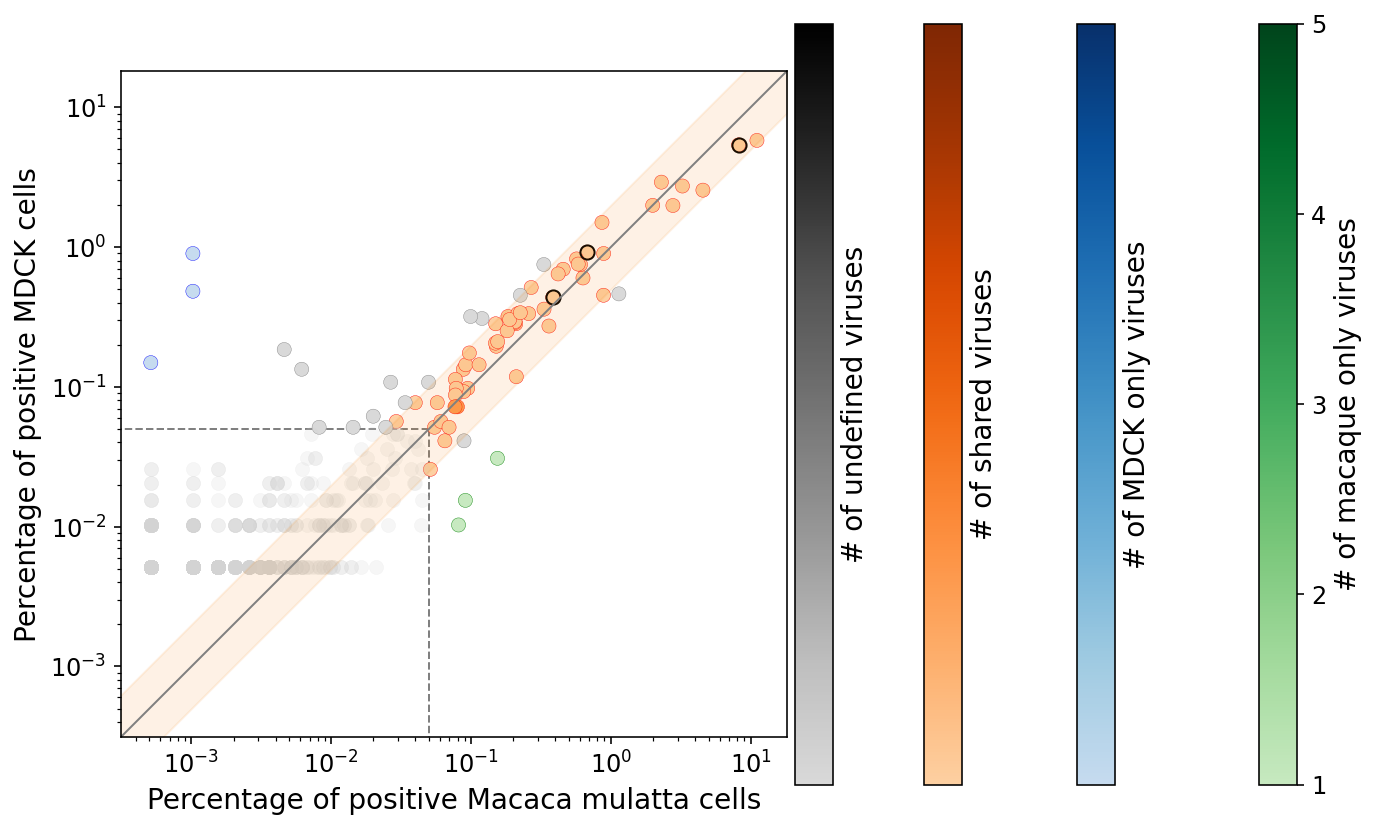

In [51]:
fig, ax = plt.subplots(figsize=(12, 10))
fontsize = 14
vmax = 5

all_v_types = ["macaca_only", "canis_only", "shared", "undefined", "below_threshold"]
labels = ["macaque only", "MDCK only", "shared", "undefined", "below threshold"]

# Generate colormaps (removing lightest values for visibility)
edgecolors = ["green", "blue", "red", "grey", "lightgrey"]
cmaps_orig = [plt.cm.Greens, plt.cm.Blues, plt.cm.Oranges, plt.cm.Greys]
min_val, max_val = 0.25, 1.0
n = 20
cmaps = []
for orig_cmap in cmaps_orig:
    colors = orig_cmap(np.linspace(min_val, max_val, n))
    cmaps.append(mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors))

for i, v_type in enumerate(all_v_types):
    # # Plot number of canis over macaque UMIs
    # x = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0))).flatten()
    # y = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0))).flatten()
    
    # Plot fraction of canis and macaque positive cells
    x = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
    y = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
    
    # Convert to percentages
    x = x*100
    y = y*100
    
    # Histogram data to show point density
    bins = [1500, 1500]
    hh, locx, locy = np.histogram2d(x, y, bins=bins)
    z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
    idx = z.argsort()
    x2, y2, z2 = x[idx], y[idx], z[idx]

    print(z2.max())
    
    # Normalize colormaps to same range
    if v_type != "below_threshold":
        scatter = ax.scatter(x2, y2, c=z2, cmap=cmaps[i], norm=mpl.colors.Normalize(vmin=1, vmax=vmax), edgecolor=edgecolors[i], lw=0.2, s=50, alpha=1)
    else:
        scatter = ax.scatter(x2, y2, c=edgecolors[i], edgecolor=edgecolors[i], lw=0.2, s=50, alpha=0.2)
    # scatter = ax.scatter(x2, y2, c=z2, cmap=cmaps[i], edgecolor=edgecolors[i], lw=0.1, s=20)

    # Add colorbar
    if v_type != "below_threshold":
        cbar = fig.colorbar(scatter, ax=ax, pad=0.01, shrink=0.7)
        cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if i == 0:
            cbar.ax.tick_params(axis="both", labelsize=fontsize-2)
        else:
            cbar.set_ticks([])
        cbar.ax.set_ylabel(f"# of {labels[i]} viruses", fontsize=fontsize)
    
# Mark u202260 with black edge
x_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u202260"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u202260"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1, s=50)

# Mark u102324 with black edge
x_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u102324"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u102324"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1, s=50)

# Mark u134800 with black edge
x_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u134800"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u134800"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1, s=50)

# ax.set_title("Total UMI counts for each virus per cell", fontsize=fontsize+2)
# ax.set_xlabel("Total Macaca mulatta UMI count", fontsize=fontsize)
# ax.set_ylabel("Total MDCK UMI count", fontsize=fontsize)
ax.set_xlabel("Percentage of positive Macaca mulatta cells", fontsize=fontsize)
ax.set_ylabel("Percentage of positive MDCK cells", fontsize=fontsize)

ax.set_xscale("log")
ax.set_yscale("log")

# Add shared threshold area and y=x line
# Get axis limits
lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

# Threshold fold change above/below x=y line
x_thres = np.array(lims)
# ax.plot(x_thres, 10**(np.log10(x_thres)+np.log10(fold_change)), c="grey", lw=1, ls="--")
# ax.plot(x_thres, 10**(np.log10(x_thres)-np.log10(fold_change)), c="grey", lw=1, ls="--")
ax.fill_between(x_thres, 10**(np.log10(x_thres)+np.log10(fold_change)), 10**(np.log10(x_thres)-np.log10(fold_change)), alpha=0.1, color="#f77f00")

# Add minimum fraction threshold lines
ax.plot([min_frac_threshold*100, min_frac_threshold*100], [min_frac_threshold*100, ax.get_xlim()[0]], c="grey", lw=1, ls="--", zorder=-1) 
ax.plot([min_frac_threshold*100, ax.get_xlim()[0]], [min_frac_threshold*100, min_frac_threshold*100], c="grey", lw=1, ls="--", zorder=-1)

ax.plot(ax.get_xlim(), ax.get_xlim(), c="grey", lw=1, ls="-")

ax.set_ylim(lims)
ax.set_xlim(lims)
ax.set_aspect("equal")

# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize-2)

# ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# ax.set_axisbelow(True)

# Save figure
# fig.savefig(
# f"figures/3.4_virus_shared_thresholds_bus_d-list.png", dpi=300, bbox_inches="tight", transparent=True
# )

fig.show()

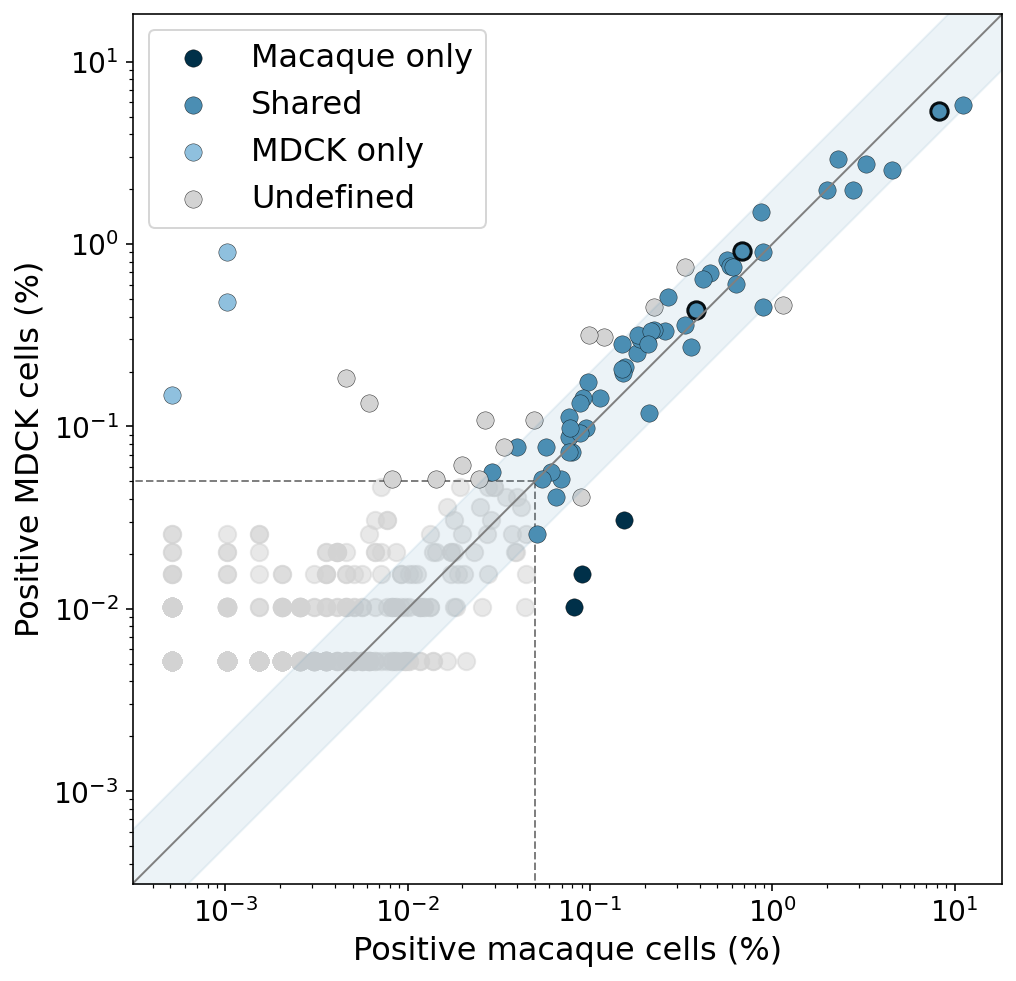

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
fontsize = 16
vmax = 5

all_v_types = ["macaca_only", "shared", "canis_only",  "undefined", "below_threshold"]
labels = ["Macaque only", "Shared", "MDCK only", "Undefined", "Below threshold"]

edgecolors = ["black", "black", "black", "black", "black"]
# colors = ["#5c2554", "#ab4e9b", "#bb7fb4", "lightgrey", "lightgrey"] # purples
colors = ["#003049", "#4b8eb3", "#8fc0de", "lightgrey", "lightgrey"]
dot_size = 75

for i, v_type in enumerate(all_v_types):
    # Plot fraction of canis and macaque positive cells
    x = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
    y = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
    
    # Convert to percentages
    x = x*100
    y = y*100
    
    if v_type == "below_threshold":
        scatter = ax.scatter(x, y, color=colors[i], s=dot_size, alpha=0.5, zorder=-1)
    else:
        scatter = ax.scatter(x, y, color=colors[i], edgecolor=edgecolors[i], lw=0.2, s=dot_size, alpha=1, label=labels[i])

    
ax.legend(fontsize=fontsize, loc="upper left")

# Mark u202260 with black edge
x_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u202260"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u202260"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1.5, s=dot_size)

# Mark u102324 with black edge
x_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u102324"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u102324"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1.5, s=dot_size)

# Mark u134800 with black edge
x_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u134800"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u134800"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1.5, s=dot_size)

# ax.set_title("Total UMI counts for each virus per cell", fontsize=fontsize+2)
# ax.set_xlabel("Total Macaca mulatta UMI count", fontsize=fontsize)
# ax.set_ylabel("Total MDCK UMI count", fontsize=fontsize)
ax.set_xlabel("Positive macaque cells (%)", fontsize=fontsize)
ax.set_ylabel("Positive MDCK cells (%)", fontsize=fontsize)

ax.set_xscale("log")
ax.set_yscale("log")

# Add shared threshold area and y=x line
# Get axis limits
lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

# Threshold fold change above/below x=y line
x_thres = np.array(lims)
# ax.plot(x_thres, 10**(np.log10(x_thres)+np.log10(fold_change)), c="grey", lw=1, ls="--")
# ax.plot(x_thres, 10**(np.log10(x_thres)-np.log10(fold_change)), c="grey", lw=1, ls="--")
ax.fill_between(x_thres, 10**(np.log10(x_thres)+np.log10(fold_change)), 10**(np.log10(x_thres)-np.log10(fold_change)), alpha=0.1, color=colors[1])

# Add minimum fraction threshold lines
ax.plot([min_frac_threshold*100, min_frac_threshold*100], [min_frac_threshold*100, ax.get_xlim()[0]], c="grey", lw=1, ls="--", zorder=-1) 
ax.plot([min_frac_threshold*100, ax.get_xlim()[0]], [min_frac_threshold*100, min_frac_threshold*100], c="grey", lw=1, ls="--", zorder=-1)

ax.plot(ax.get_xlim(), ax.get_xlim(), c="grey", lw=1, ls="-")

ax.set_ylim(lims)
ax.set_xlim(lims)
ax.set_aspect("equal")

# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize-2)

# ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# ax.set_axisbelow(True)

# Save figure
fig.savefig(
    f"figures/3.4_virus_shared_thresholds_bus_d-list.png", dpi=300, bbox_inches="tight", transparent=True
)

fig.show()

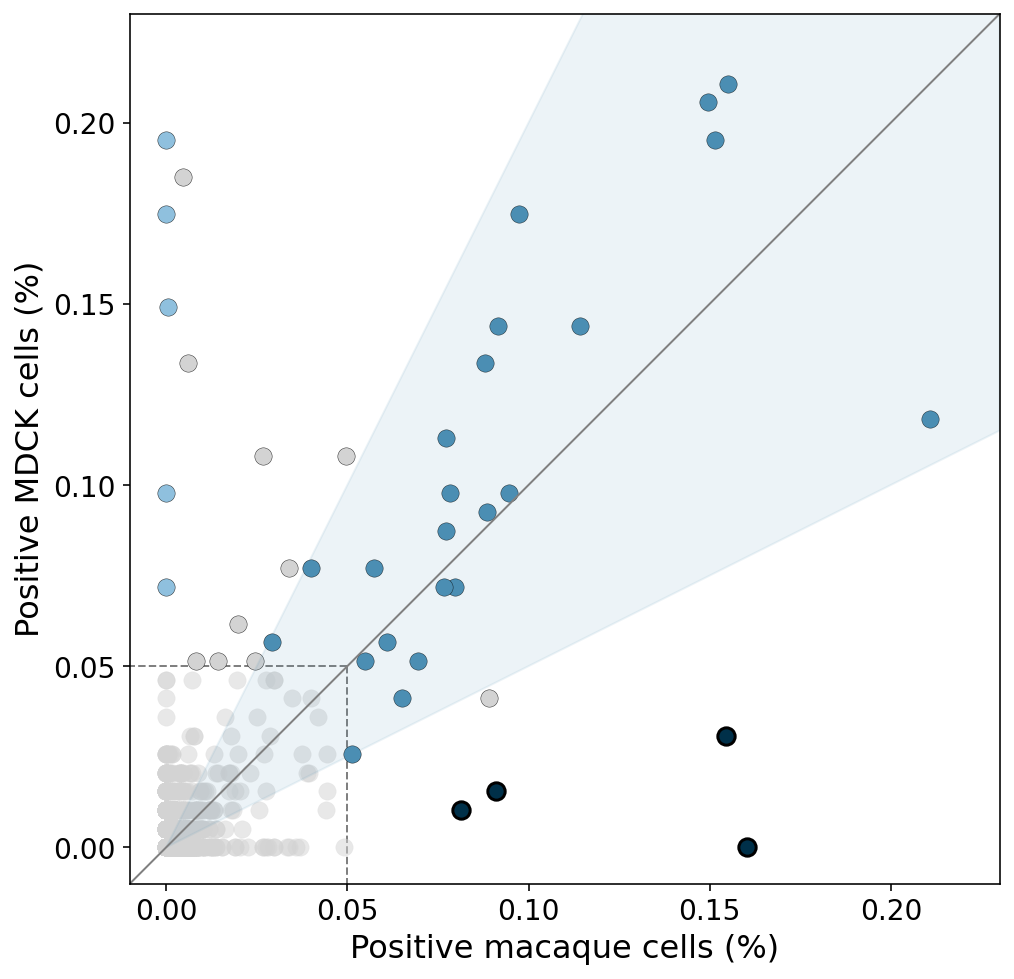

In [53]:
# Zoom into area around 0
fig, ax = plt.subplots(figsize=(8, 8))
fontsize = 16
vmax = 5

all_v_types = ["macaca_only", "shared", "canis_only",  "undefined", "below_threshold"]
labels = ["macaque only", "shared", "MDCK only", "undefined", "below threshold"]

edgecolors = ["black", "black", "black", "black", "black"]
# colors = ["#5c2554", "#ab4e9b", "#bb7fb4", "lightgrey", "lightgrey"] # purples
colors = ["#003049", "#4b8eb3", "#8fc0de", "lightgrey", "lightgrey"]

for i, v_type in enumerate(all_v_types):
    # Plot fraction of canis and macaque positive cells
    x = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
    y = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
    
    # Convert to percentages
    x = x*100
    y = y*100
    
    # Normalize colormaps to same range
    if v_type == "below_threshold":
        scatter = ax.scatter(x, y, color=colors[i], lw=0.2, s=dot_size, alpha=0.5)
    else:
        scatter = ax.scatter(x, y, color=colors[i], edgecolor=edgecolors[i], lw=0.2, s=dot_size, alpha=1)


# Mark Ebolavirus with black edge
x_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u10"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u10"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1.5, s=dot_size)

# Mark u102540 with black edge
x_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u102540"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u102540"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1.5, s=dot_size)

# Mark u11150 with black edge
x_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u11150"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u11150"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1.5, s=dot_size)

# Mark u39566 with black edge
x_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u39566"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u39566"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1.5, s=dot_size)

# ax.set_title("Total UMI counts for each virus per cell", fontsize=fontsize+2)
# ax.set_xlabel("Total Macaca mulatta UMI count", fontsize=fontsize)
# ax.set_ylabel("Total MDCK UMI count", fontsize=fontsize)
ax.set_xlabel("Positive macaque cells (%)", fontsize=fontsize)
ax.set_ylabel("Positive MDCK cells (%)", fontsize=fontsize)

# Show 0 values
# ax.set_xscale("symlog")
# ax.set_yscale("symlog")

ax.set_ylim(bottom=-0.01, top=0.23)
ax.set_xlim(left=-0.01, right=0.23)

# Add shared threshold area and y=x line
# Get axis limits
lims = [
        0.0001,
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

# Threshold fold change above/below x=y line
x_thres = np.array(lims)
# ax.plot(x_thres, 10**(np.log10(x_thres)+np.log10(fold_change)), c="grey", lw=1, ls="--")
# ax.plot(x_thres, 10**(np.log10(x_thres)-np.log10(fold_change)), c="grey", lw=1, ls="--")
ax.fill_between(x_thres, 10**(np.log10(x_thres)+np.log10(fold_change)), 10**(np.log10(x_thres)-np.log10(fold_change)), alpha=0.1, color=colors[1])

# Add minimum fraction threshold lines
ax.plot([min_frac_threshold*100, min_frac_threshold*100], [min_frac_threshold*100, -1], c="grey", lw=1, ls="--", zorder=-1) 
ax.plot([min_frac_threshold*100, -1], [min_frac_threshold*100, min_frac_threshold*100], c="grey", lw=1, ls="--", zorder=-1)

ax.plot(ax.get_xlim(), ax.get_xlim(), c="grey", lw=1, ls="-")

ax.set_aspect("equal")

# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize-2)

# ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# ax.set_axisbelow(True)

# Save figure
fig.savefig(
    f"figures/3.4_virus_shared_thresholds_zero_bus_d-list.png", dpi=300, bbox_inches="tight"
)

fig.show()

1.0
1.0
2.0
1.0
6895.0


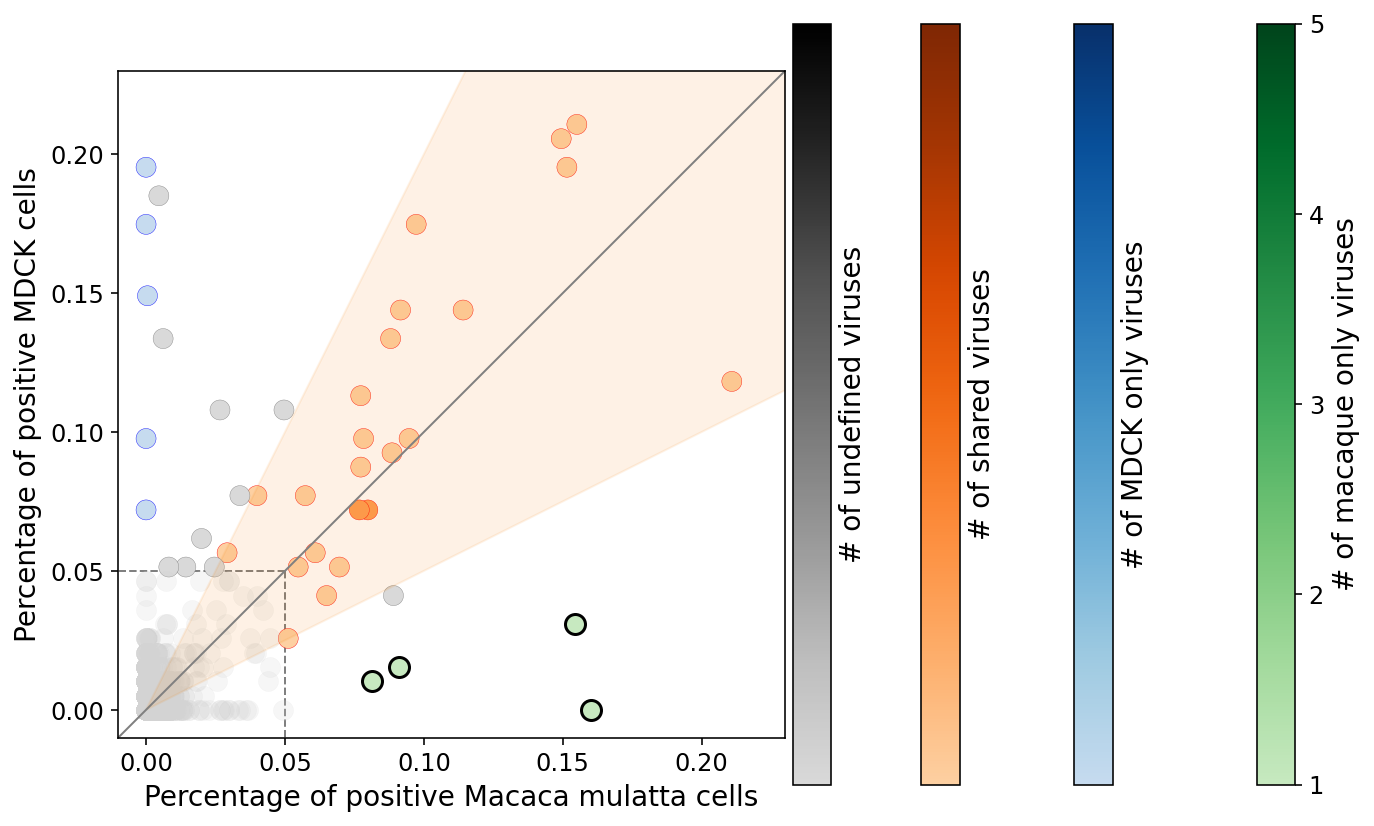

In [54]:
# Zoom into area around 0
fig, ax = plt.subplots(figsize=(12, 10))
fontsize = 14
vmax = 5

all_v_types = ["macaca_only", "canis_only", "shared", "undefined", "below_threshold"]
labels = ["macaque only", "MDCK only", "shared", "undefined", "below threshold"]

# Generate colormaps (removing lightest values for visibility)
edgecolors = ["green", "blue", "red", "grey", "lightgrey"]
cmaps_orig = [plt.cm.Greens, plt.cm.Blues, plt.cm.Oranges, plt.cm.Greys]
min_val, max_val = 0.25, 1.0
n = 20
cmaps = []
for orig_cmap in cmaps_orig:
    colors = orig_cmap(np.linspace(min_val, max_val, n))
    cmaps.append(mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors))

for i, v_type in enumerate(all_v_types):
    # # Plot number of canis over macaque UMIs
    # x = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0))).flatten()
    # y = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0))).flatten()
    
    # Plot fraction of canis and macaque positive cells
    x = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
    y = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
    
    # Convert to percentages
    x = x*100
    y = y*100
    
    # Histogram data to show point density
    bins = [1500, 1500]
    hh, locx, locy = np.histogram2d(x, y, bins=bins)
    z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
    idx = z.argsort()
    x2, y2, z2 = x[idx], y[idx], z[idx]

    print(z2.max())
    
    # Normalize colormaps to same range
    if v_type != "below_threshold":
        scatter = ax.scatter(x2, y2, c=z2, cmap=cmaps[i], norm=mpl.colors.Normalize(vmin=1, vmax=vmax), edgecolor=edgecolors[i], lw=0.2, s=100, alpha=1)
    else:
        scatter = ax.scatter(x2, y2, c=edgecolors[i], edgecolor=edgecolors[i], lw=0.2, s=100, alpha=0.2)
    # scatter = ax.scatter(x2, y2, c=z2, cmap=cmaps[i], edgecolor=edgecolors[i], lw=0.1, s=20)

    # Add colorbar
    if v_type != "below_threshold":
        cbar = fig.colorbar(scatter, ax=ax, pad=0.01, shrink=0.7)
        cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if i == 0:
            cbar.ax.tick_params(axis="both", labelsize=fontsize-2)
        else:
            cbar.set_ticks([])
        cbar.ax.set_ylabel(f"# of {labels[i]} viruses", fontsize=fontsize)
    
# Mark Ebolavirus with black edge
x_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u10"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u10"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1.5, s=100)

# Mark u102540 with black edge
x_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u102540"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u102540"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1.5, s=100)

# Mark u11150 with black edge
x_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u11150"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u11150"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1.5, s=100)

# Mark u39566 with black edge
x_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u39566"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
y_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u39566"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1.5, s=100)

# ax.set_title("Total UMI counts for each virus per cell", fontsize=fontsize+2)
# ax.set_xlabel("Total Macaca mulatta UMI count", fontsize=fontsize)
# ax.set_ylabel("Total MDCK UMI count", fontsize=fontsize)
ax.set_xlabel("Percentage of positive Macaca mulatta cells", fontsize=fontsize)
ax.set_ylabel("Percentage of positive MDCK cells", fontsize=fontsize)

# Show 0 values
# ax.set_xscale("symlog")
# ax.set_yscale("symlog")

ax.set_ylim(bottom=-0.01, top=0.23)
ax.set_xlim(left=-0.01, right=0.23)

# Add shared threshold area and y=x line
# Get axis limits
lims = [
        0.0001,
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

# Threshold fold change above/below x=y line
x_thres = np.array(lims)
# ax.plot(x_thres, 10**(np.log10(x_thres)+np.log10(fold_change)), c="grey", lw=1, ls="--")
# ax.plot(x_thres, 10**(np.log10(x_thres)-np.log10(fold_change)), c="grey", lw=1, ls="--")
ax.fill_between(x_thres, 10**(np.log10(x_thres)+np.log10(fold_change)), 10**(np.log10(x_thres)-np.log10(fold_change)), alpha=0.1, color="#f77f00")

# Add minimum fraction threshold lines
ax.plot([min_frac_threshold*100, min_frac_threshold*100], [min_frac_threshold*100, -1], c="grey", lw=1, ls="--", zorder=-1) 
ax.plot([min_frac_threshold*100, -1], [min_frac_threshold*100, min_frac_threshold*100], c="grey", lw=1, ls="--", zorder=-1)

ax.plot(ax.get_xlim(), ax.get_xlim(), c="grey", lw=1, ls="-")

ax.set_aspect("equal")

# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize-2)

# ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# ax.set_axisbelow(True)

# Save figure
fig.savefig(
    f"figures/3.4_virus_shared_thresholds_zero_bus_d-list.png", dpi=300, bbox_inches="tight", transparent=True
)

fig.show()

In [55]:
%%time
# Same for host

# Get fraction of positive cells for each virus for each species
mac_fractions = nd(palmdb_adata_host[palmdb_adata_host.obs["species"] == "macaca_mulatta", :].X.sum(axis=0)) / len(palmdb_adata_host.obs[palmdb_adata_host.obs["species"] == "macaca_mulatta"])
can_fractions = nd(palmdb_adata_host[palmdb_adata_host.obs["species"] == "canis_lupus_familiaris", :].X.sum(axis=0)) / len(palmdb_adata_host.obs[palmdb_adata_host.obs["species"] == "canis_lupus_familiaris"])

v_types = []
for mac_frac, can_frac in zip(mac_fractions, can_fractions):
    if mac_frac < min_frac_threshold and can_frac < min_frac_threshold:
        v_types.append("below_threshold")
    elif mac_frac > can_frac and mac_frac / can_frac <= fold_change:
        v_types.append("shared")
    elif can_frac > mac_frac and can_frac / mac_frac <= fold_change:
        v_types.append("shared")
    elif mac_frac > can_frac and can_frac <= (min_num_cells / len(palmdb_adata_host.obs[palmdb_adata_host.obs["species"] == "canis_lupus_familiaris"])): # Allow [min_num_cells] positive cells in the other species
        v_types.append("macaca_only")
    elif can_frac > mac_frac and mac_frac <= (min_num_cells / len(palmdb_adata_host.obs[palmdb_adata_host.obs["species"] == "macaca_mulatta"])):
        v_types.append("canis_only")
    else:
        v_types.append("undefined")
        
palmdb_adata_host.var["v_type"] = v_types

<timed exec>:13: RuntimeWarning: divide by zero encountered in float_scalars
<timed exec>:11: RuntimeWarning: divide by zero encountered in float_scalars


CPU times: user 1.19 s, sys: 33 ms, total: 1.22 s
Wall time: 1.22 s


In [56]:
Counter(v_types)

Counter({'below_threshold': 4845,
         'shared': 56,
         'macaca_only': 67,
         'canis_only': 233,
         'undefined': 65})

Filter based on hard-coded count or positive cell percentages:

In [57]:
# %%time
# # Maximum virus count percentage allowed from other species to not be considered shared
# threshold = 0.1

# v_types = []
# for virus_id in palmdb_adata.var.index.values:
#     # Get total number of counts for virus from each species
#     mc = palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index == virus_id].X.sum()
#     cc = palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index == virus_id].X.sum()
    
#     if mc > 0 or cc > 0:
#         if cc / mc <= threshold:
#             v_types.append("macaca_only")

#         elif mc / cc <= threshold:
#             v_types.append("canis_only")

#         else:
#             v_types.append("shared")
        
#     else:
#         v_types.append("not_seen")

In [58]:
# %%time
# # Fraction of positive cells in other species beyond which the virus is considered shared
# threshold = 0.0001

# v_types = []
# for virus_id in palmdb_adata.var.index.values:
#     # Get fraction of positive cells for virus from each species
#     mc = palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index == virus_id].X.sum() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
#     cc = palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index == virus_id].X.sum() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
    
#     if mc > 0 or cc > 0:
#         if cc >= threshold and mc < threshold:
#             v_types.append("canis_only")

#         elif cc < threshold and mc >= threshold:
#             v_types.append("macaca_only")

#         elif cc < threshold and mc < threshold:
#             v_types.append("undefined")
            
#         else:
#             v_types.append("shared")
        
#     else:
#         v_types.append("not_seen")

In [59]:
# # Number of cells the virus is in
# len(palmdb_adata.obs) * threshold * 100

In [60]:
# palmdb_adata.var["v_type"] = v_types

In [61]:
# %%time
# # fig, ax = plt.subplots(figsize=(12, 12))
# fig = plt.figure(figsize=(12, 12))
# gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
#                       left=0.1, right=0.9, bottom=0.1, top=0.9,
#                       wspace=0.05, hspace=0.05)
# ax = fig.add_subplot(gs[1, 0])

# fontsize = 14

# v_types = ["macaca_only", "canis_only", "shared", "undefined"]
# labels = ["macaque only", "MDCK only", "shared", "undefined"]

# # Generate colormaps (removing lightest values for visibility)
# edgecolors = ["green", "blue", "red", "grey"]
# cmaps_orig = [plt.cm.Greens, plt.cm.Blues, plt.cm.Oranges, plt.cm.Greys]
# min_val, max_val = 0.25, 1.0
# n = 20
# cmaps = []
# for orig_cmap in cmaps_orig:
#     colors = orig_cmap(np.linspace(min_val, max_val, n))
#     cmaps.append(mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors))

# for i, v_type in enumerate(v_types):
#     # # Plot number of canis over macaque UMIs
#     # x = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0))).flatten()
#     # y = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0))).flatten()
    
#     # Plot fraction of canis and macaque positive cells
#     x = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
#     y = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
    
#     # Convert to percentages
#     x = x*100
#     y = y*100
    
#     # Histogram data to show point density
#     bins = [1500, 1500]
#     hh, locx, locy = np.histogram2d(x, y, bins=bins)
#     z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
#     idx = z.argsort()
#     x2, y2, z2 = x[idx], y[idx], z[idx]

#     print(z2.max())
    
#     # Normalize colormaps to same range
#     scatter = ax.scatter(x2, y2, c=z2, cmap=cmaps[i], norm=mpl.colors.Normalize(vmin=1, vmax=28), edgecolor=edgecolors[i], lw=0.2, s=50, alpha=1)
#     # scatter = ax.scatter(x2, y2, c=z2, cmap=cmaps[i], edgecolor=edgecolors[i], lw=0.1, s=20)

# #     # Add colorbar
# #     cbar = fig.colorbar(scatter, ax=ax, pad=0.01, shrink=0.6)
# #     if i == 0:
# #         cbar.ax.tick_params(axis="both", labelsize=fontsize-2)
# #     else:
# #         cbar.set_ticks([])
# #     cbar.ax.set_ylabel(f"# of {labels[i]} viruses", fontsize=fontsize)
    
# # Mark u202260 with black edge
# x_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u202260"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
# y_ebov = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u202260"].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
# ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1, s=50)

# # Add lines to show threshold cutoffs
# ax.axhline(threshold*100, color="grey", lw=1, ls="--")
# ax.axvline(threshold*100, color="grey", lw=1, ls="--")

# # ax.set_title("Total UMI counts for each virus per cell", fontsize=fontsize+2)
# # ax.set_xlabel("Total Macaca mulatta UMI count", fontsize=fontsize)
# # ax.set_ylabel("Total MDCK UMI count", fontsize=fontsize)
# ax.set_xlabel("Percentage of positive Macaca mulatta cells", fontsize=fontsize)
# ax.set_ylabel("Percentage of positive MDCK cells", fontsize=fontsize)

# ax.set_xscale("log")
# ax.set_yscale("log")

# # Add y=x line
# yex(ax)

# bottom=0.0009
# top=13
# ax.set_ylim(bottom=bottom, top=top)
# ax.set_xlim(left=bottom, right=top)

# # Change fontsize of tick labels
# ax.tick_params(axis="both", labelsize=fontsize-2)

# # ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# # ax.set_axisbelow(True)

# # Plot histograms
# bins_x = 8000
# x_hist = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", :].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
# ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
# ax_histx.hist(x_hist*100, bins=bins_x, histtype='stepfilled', color="white", edgecolor="black", lw=1)
# ax_histx.set_yscale("log")
# # Add lines to show threshold cutoffs
# ax_histx.axvline(threshold*100, color="grey", lw=1, ls="--")
# ax_histx.tick_params(axis="x", labelbottom=False)
# ax.set_xlim(left=bottom, right=top)

# bins_y = 3000
# y_hist = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", :].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
# ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# ax_histy.hist(y_hist*100, bins=bins_y, histtype='stepfilled', orientation="horizontal", color="white", edgecolor="black", lw=1)
# ax_histy.set_xscale("log")
# # Add lines to show threshold cutoffs
# ax_histy.axhline(threshold*100, color="grey", lw=1, ls="--")
# ax_histy.tick_params(axis="y", labelleft=False)
# ax.set_ylim(bottom=bottom, top=top)

# # Save figure
# fig.savefig(
#     f"figures/3.4_virus_shared_thresholds.png", dpi=300, bbox_inches="tight"
# )

# fig.show()

In [62]:
# %%time
# fig = plt.figure(figsize=(12, 12))
# gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
#                       left=0.1, right=0.9, bottom=0.1, top=0.9,
#                       wspace=0.05, hspace=0.05)

# fontsize = 14

# ax = fig.add_subplot(gs[1, 0])

# v_types = ["macaca_only", "canis_only", "shared", "undefined"]
# labels = ["macaque only", "MDCK only", "shared", "undefined"]

# # Generate colormaps (removing lightest values for visibility)
# edgecolors = ["green", "blue", "red", "grey"]
# cmaps_orig = [plt.cm.Greens, plt.cm.Blues, plt.cm.Oranges, plt.cm.Greys]
# min_val, max_val = 0.25, 1.0
# n = 20
# cmaps = []
# for orig_cmap in cmaps_orig:
#     colors = orig_cmap(np.linspace(min_val, max_val, n))
#     cmaps.append(mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors))

# for i, v_type in enumerate(v_types):
#     # # Plot number of canis over macaque UMIs
#     # x = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0))).flatten()
#     # y = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0))).flatten()
    
#     # Plot fraction of canis and macaque positive cells
#     x = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
#     y = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var["v_type"] == v_type].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
    
#     # Convert to percentages
#     x = x*100
#     y = y*100
    
#     # Histogram data to show point density
#     bins = [1500, 1500]
#     hh, locx, locy = np.histogram2d(x, y, bins=bins)
#     z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
#     idx = z.argsort()
#     x2, y2, z2 = x[idx], y[idx], z[idx]

#     print(z2.max())
    
#     # Normalize colormaps to same range
#     scatter = ax.scatter(x2, y2, c=z2, cmap=cmaps[i], norm=mpl.colors.Normalize(vmin=1, vmax=28), edgecolor=edgecolors[i], lw=0.2, s=50, alpha=1)
#     # scatter = ax.scatter(x2, y2, c=z2, cmap=cmaps[i], edgecolor=edgecolors[i], lw=0.1, s=20)

#     # # Add colorbar
#     # cbar = fig.colorbar(scatter, ax=ax, pad=0.15, shrink=0.5)
#     # if i == 0:
#     #     cbar.ax.tick_params(axis="both", labelsize=fontsize-2)
#     # else:
#     #     cbar.set_ticks([])
#     # cbar.ax.set_ylabel(f"# of {labels[i]} viruses", fontsize=fontsize)

# # Mark Ebolavirus with black edge
# x_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", palmdb_adata.var.index=="u10"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
# y_ebov = (np.array(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", palmdb_adata.var.index=="u10"].X.sum(axis=0))).flatten() / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
# ax.scatter(x_ebov*100, y_ebov*100, facecolor=[0, 0, 0, 0], edgecolor=[0, 0, 0, 1], lw=1, s=50)
    
# # Add lines to show threshold cutoffs
# ax.axhline(threshold*100, color="grey", lw=1, ls="--")
# ax.axvline(threshold*100, color="grey", lw=1, ls="--")

# # ax.set_title("Total UMI counts for each virus per cell", fontsize=fontsize+2)
# # ax.set_xlabel("Total Macaca mulatta UMI count", fontsize=fontsize)
# # ax.set_ylabel("Total MDCK UMI count", fontsize=fontsize)
# ax.set_xlabel("Percentage of positive Macaca mulatta cells", fontsize=fontsize)
# ax.set_ylabel("Percentage of positive MDCK cells", fontsize=fontsize)

# ax.set_xscale("symlog")
# ax.set_yscale("symlog")

# # Add y=x line
# yex(ax)

# ax.set_ylim(bottom=-0.01, top=0.165)
# ax.set_xlim(left=-0.01, right=0.165)

# # Change fontsize of tick labels
# ax.tick_params(axis="both", labelsize=fontsize-2)

# # ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
# # ax.set_axisbelow(True)

# # Plot histograms
# bins_x = 5000
# x_hist = nd(palmdb_adata[palmdb_adata.obs["species"] == "macaca_mulatta", :].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "macaca_mulatta"])
# ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
# ax_histx.hist(x_hist*100, bins=bins_x, histtype='stepfilled', color="white", edgecolor="black", lw=1)
# ax_histx.set_yscale("log")
# ax_histx.set_xlim(left=-0.01, right=0.165)
# # Add lines to show threshold cutoffs
# ax_histx.axvline(threshold*100, color="grey", lw=1, ls="--")
# ax_histx.tick_params(axis="x", labelbottom=False)

# bins_y = 2000
# y_hist = nd(palmdb_adata[palmdb_adata.obs["species"] == "canis_lupus_familiaris", :].X.sum(axis=0)) / len(palmdb_adata.obs[palmdb_adata.obs["species"] == "canis_lupus_familiaris"])
# ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# ax_histy.hist(y_hist*100, bins=bins_y, histtype='stepfilled', orientation="horizontal", color="white", edgecolor="black", lw=1)
# ax_histy.set_xscale("log")
# ax_histy.set_ylim(bottom=-0.01, top=0.165)
# # Add lines to show threshold cutoffs
# ax_histy.axhline(threshold*100, color="grey", lw=1, ls="--")
# ax_histy.tick_params(axis="y", labelleft=False)

# plt.tight_layout()

# # Save figure
# fig.savefig(
#     f"figures/3.4_virus_shared_thresholds_zeros.png", dpi=300, bbox_inches="tight"
# )

# fig.show()

# For each virus, plot number of only virus / also in host reads

In [63]:
# Macaque only + shared viruses in order of heatmap
virs = ['u39566', 'u102540', 'u11150', 'u10', 'u288819','u290519','u10240','u183255','u1001','u100291','u103829','u110641','u181379','u202260','u135858','u101227','u100188','u27694','u34159','u100245','u10015','u100733','u100173','u100196','u100599','u100644','u100296','u100017','u100002','u100012','u100024','u100048','u100302','u100074','u100289','u100026','u100111','u100139','u100154','u100251','u100177','u100215','u100049','u100000','u100001','u100007','u100004','u100011','u100093','u100116','u100019','u100076','u100028','u100153','u100031','u100145','u102324','u134800']
vir_fracs = []
host_fracs = []
for i, vir in enumerate(virs):
    vir_count = palmdb_adata.raw[:, palmdb_adata.var.index == vir].X.sum()
    host_count = palmdb_adata_host.raw[:, palmdb_adata_host.var.index == vir].X.sum()
    total = vir_count + host_count
    
    vir_fracs.append(vir_count / total)
    host_fracs.append(host_count / total)
    
df_read_fracs = pd.DataFrame()
df_read_fracs["vir"] = virs
df_read_fracs["vir_frac"] = vir_fracs
df_read_fracs["host_frac"] = host_fracs

df_read_fracs = df_read_fracs.sort_values("vir_frac", ascending=False)

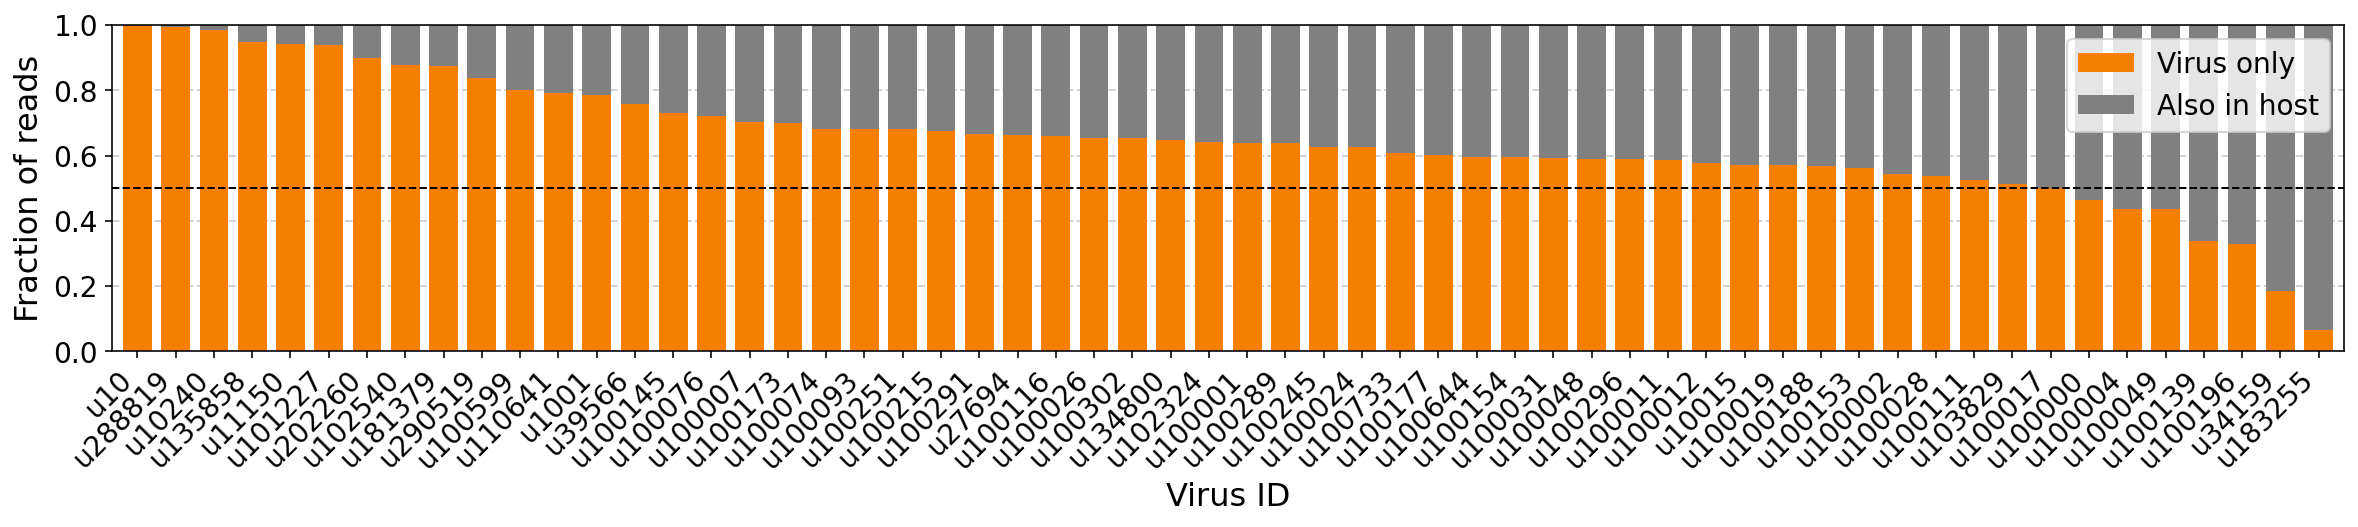

In [64]:
fig, ax = plt.subplots(figsize=(20, 3))
fontsize = 14
width = 0.75

for i, vir in enumerate(df_read_fracs["vir"].values):
    vir_frac = df_read_fracs[df_read_fracs["vir"] == vir]["vir_frac"].values[0]
    host_frac = df_read_fracs[df_read_fracs["vir"] == vir]["host_frac"].values[0]
    if i == 0:
        ax.bar(i, vir_frac, width=width, label="Virus only", color="#f77f00")
        ax.bar(i, host_frac, bottom=vir_frac, label="Also in host", width=width, color="#808080")
    else:
        ax.bar(i, vir_frac, width=width, color="#f77f00")
        ax.bar(i, host_frac, bottom=vir_frac, width=width, color="#808080")
        
ax.set_ylabel("Fraction of reads", fontsize=fontsize+2)
ax.set_xlabel("Virus ID", fontsize=fontsize+2)
ax.set_xticks(np.arange(len(df_read_fracs["vir"].values)), df_read_fracs["vir"].values, rotation=45, ha="right", fontsize=fontsize)
ax.margins(x=0.005, y=0)
ax.legend(fontsize=fontsize, loc="upper right")
ax.tick_params(axis='both', labelsize=fontsize)

ax.axhline(0.5, color="black", ls="--", lw=1)

ax.grid(True, which="both", color="lightgrey", ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)

plt.savefig("figures/3.4_frac_per_capture_type.png", dpi=300, bbox_inches="tight")

fig.show()

In [65]:
palmdb_adata_host.raw[:, palmdb_adata_host.var.index == "u10"].X.sum()

2.0

# Plot count histogram to show low counts per virus ID (compared to host) before binarizing:

In [66]:
palmdb_adata_temp = palmdb_adata.raw[palmdb_adata.obs["celltype"].notnull(), palmdb_adata.var["v_type"] == "macaca_only"].X
vir_counts = nd(palmdb_adata_temp[palmdb_adata_temp>0])

palmdb_adata_temp = palmdb_adata.raw[palmdb_adata.obs["celltype"].notnull(), palmdb_adata.var["v_type"] == "shared"].X
vir_counts2 = nd(palmdb_adata_temp[palmdb_adata_temp>0])

host_counts = nd(mac_adata.raw.X[mac_adata.raw.X>0])

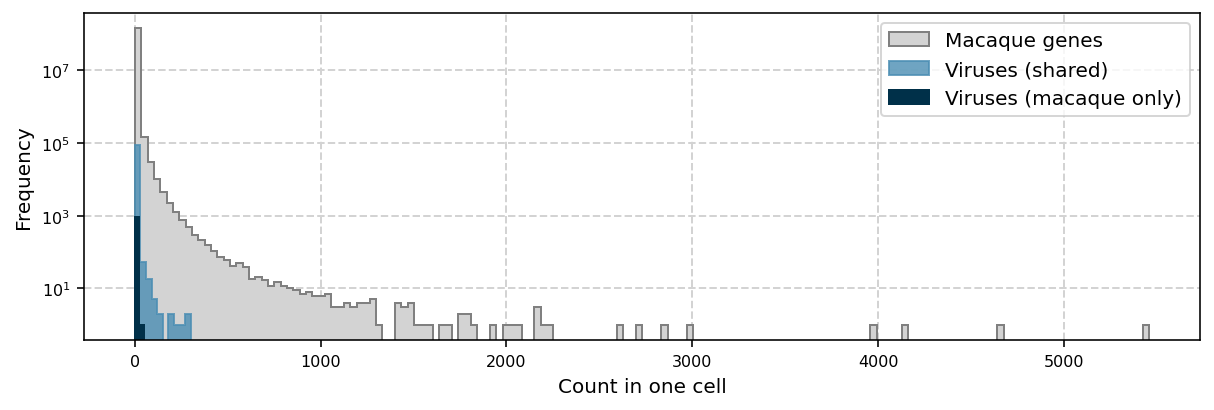

In [69]:
fig, ax = plt.subplots(figsize=(10, 3))
fontsize = 10

ax.hist(host_counts, bins=160, histtype='stepfilled', edgecolor="grey", facecolor="lightgrey", label="Macaque genes", log=True)
ax.hist(vir_counts2, bins=10, histtype='stepfilled', edgecolor="#4b8eb3", facecolor="#4b8eb3", alpha=0.8, label="Viruses (shared)", log=True)
ax.hist(vir_counts, bins=2, histtype='stepfilled', edgecolor="#003049", facecolor="#003049", alpha=1, label="Viruses (macaque only)", log=True)

ax.legend(fontsize=fontsize)

ax.set_xlabel("Count in one cell", fontsize=fontsize)
ax.set_ylabel("Frequency", fontsize=fontsize)

# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize-2)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

plt.savefig("figures/3.4_count_histogram_bus_d-list.png", dpi=300, bbox_inches="tight")

fig.show()

___

In [142]:
# Save new binarized virus matrix including host species information and virus types
palmdb_adata.write(f"{fastq_folder}/host_flag/virus_cdna_dna_masked_meta.h5ad")
palmdb_adata_host.write(f"{fastq_folder}/host_flag/virus_cdna_dna_also-in-host_meta.h5ad")